In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# Desactivo warning molesto
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
eventos = pd.read_csv('/home/lautaro/Desktop/events_up_to_01062018.csv', low_memory=False)

In [4]:
labels = pd.read_csv('/home/lautaro/Desktop/labels_training_set.csv')

In [5]:
eventos.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
labels.head()

,person,label
0,0566e9c1,0
1,6ec7ee77,0
2,abe7a2fb,0
3,34728364,0
4,87ed62de,0


In [7]:
eventos["timestamp"] = pd.to_datetime(eventos["timestamp"])

El csv de labels tiene las personas y un booleano indicando si compraron. Por lo tanto mi objetivo es transformar el csv de eventos en uno que tenga información para cada persona.

In [8]:
# Como estoy evaluando a los usuarios no me interesa los eventos que no tengan una persona asociada
eventos.loc[eventos['person'].isnull() == True,:]

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version


In [9]:
eventos["busquedas_exactas"] = (eventos["search_term"].notnull() & eventos["search_term"].isin(eventos['model'].unique()))

In [10]:
eventos["terminos_buscados"] = eventos['search_term'].replace(np.nan, '', regex=True).str.split().apply(len)

In [11]:
eventos['marca'] = eventos['model'].str.split(' ', n = 1, expand = True)[0]

In [12]:
eventos['Samsung'] = (eventos['marca'] == 'Samsung')
eventos['iPhone'] = (eventos['marca'] == 'iPhone')
eventos['LG'] = (eventos['marca'] == 'LG')
eventos['Motorola'] = (eventos['marca'] == 'Motorola')
eventos['iPad'] = (eventos['marca'] == 'iPad')
eventos['Sony'] = (eventos['marca'] == 'Sony')
eventos['Lenovo'] = (eventos['marca'] == 'Lenovo')
eventos['Quantum'] = (eventos['marca'] == 'Quantum')
eventos['Asus'] = (eventos['marca'] == 'Asus')
eventos['Xiaomi'] = (eventos['marca'] == 'Xiaomi')
eventos['Outros'] = (eventos['marca'] == 'Outros')

In [13]:
eventos['Bom'] = (eventos['condition'] == 'Bom')
eventos['Muito_Bom'] = (eventos['condition'] == 'Muito Bom')
eventos['Excelente'] = (eventos['condition'] == 'Excelente')

Se me ocurre que podría extraer la columa "event" y hacer una columna por cada evento con un booleano, esto me ayudaria a contar la cantidad de veces que se registraron los eventos para cada usuario.

In [14]:
eventos['viewed_product'] = (eventos['event'] == 'viewed product')
eventos['brand_listing'] = (eventos['event'] == 'brand listing')
eventos['visited_site'] = (eventos['event'] == 'visited site')
eventos['ad_campaign_hit'] = (eventos['event'] == 'ad campaign hit')
eventos['generic_listing'] = (eventos['event'] == 'generic listing')
eventos['searched_products'] = (eventos['event'] == 'searched products')
eventos['search_engine_hit'] = (eventos['event'] == 'search engine hit')
eventos['checkout'] = (eventos['event'] == 'checkout')
eventos['staticpage'] = (eventos['event'] == 'staticpage')
eventos['conversion'] = (eventos['event'] == 'conversion')
eventos['lead'] = (eventos['event'] == 'lead')
eventos['total_eventos'] = 1;

In [15]:
eventos.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,brand_listing,visited_site,ad_campaign_hit,generic_listing,searched_products,search_engine_hit,checkout,conversion,lead,total_eventos
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,...,False,False,False,False,False,False,False,False,False,1
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,...,False,False,False,False,False,False,False,False,False,1
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,...,False,False,False,False,False,False,False,False,False,1
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,...,False,False,False,False,False,False,False,False,False,1
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,...,False,False,False,False,False,False,False,False,False,1


La columna "timestamp" me parece muy importante pero como voy a tener que agrupar todos los eventos de una persona a una sola fila necesito hacer algo con ella. Se me ocurre que puedo agregar columnas para determinar si cada evento tuvo lugar por ejemplo una columa por mes. Esta creación de columnas va a estar muy ligada al hecho que los datos que tenemos van desde principio de este año hasta junio.

In [16]:
eventos["mes"] = eventos["timestamp"].dt.month
eventos["dia_del_anio"] = eventos["timestamp"].dt.dayofyear
eventos["semana"] = eventos["timestamp"].dt.week

In [17]:
# Obtengo la ultima fecha disponible en el csv para tener un punto de partida
ultima_fecha = eventos["timestamp"].max()
ultimo_dia = ultima_fecha.dayofyear
ultimo_mes = ultima_fecha.month
ultima_semana = ultima_fecha.week

In [18]:
# Agrego columna para obtener los dias desde el evento
eventos["dias_ultimo_evento"] = (ultimo_dia - eventos["dia_del_anio"])

In [19]:
# Agrego columna para saber hace cuanto compro en la pagina
eventos["dias_ultima_compra"] = ultimo_dia
eventos.loc[eventos["conversion"] == True, "dias_ultima_compra"] = ultimo_dia - eventos["dia_del_anio"]

In [20]:
# Agrego columnas para los m meses más cercanos
for m in range (0, ultimo_mes):
    eventos["mes_pasado_" + str(m)] = (eventos["mes"] == (ultimo_mes - m))
    eventos['viewed_product_mes_pasado_' + str(m)] = ((eventos['event'] == 'viewed product') & (eventos["mes_pasado_" + str(m)] == True))
    eventos['brand_listing_mes_pasado_' + str(m)] = ((eventos['event'] == 'brand listing') & (eventos["mes_pasado_" + str(m)] == True))
    eventos['visited_site_mes_pasado_' + str(m)] = ((eventos['event'] == 'visited site') & (eventos["mes_pasado_" + str(m)] == True))
    eventos['ad_campaign_hit_mes_pasado_' + str(m)] = ((eventos['event'] == 'ad campaign hit') & (eventos["mes_pasado_" + str(m)] == True))
    eventos['generic_listing_mes_pasado_' + str(m)] = ((eventos['event'] == 'generic listing') & (eventos["mes_pasado_" + str(m)] == True))
    eventos['searched_products_mes_pasado_' + str(m)] = ((eventos['event'] == 'searched products') & (eventos["mes_pasado_" + str(m)] == True))
    eventos['search_engine_hit_mes_pasado_' + str(m)] = ((eventos['event'] == 'search engine hit') & (eventos["mes_pasado_" + str(m)] == True))
    eventos['checkout_mes_pasado_' + str(m)] = ((eventos['event'] == 'checkout') & (eventos["mes_pasado_" + str(m)] == True))
    eventos['staticpage_mes_pasado_' + str(m)] = ((eventos['event'] == 'staticpage') & (eventos["mes_pasado_" + str(m)] == True))
    eventos['conversion_mes_pasado_' + str(m)] = ((eventos['event'] == 'conversion') & (eventos["mes_pasado_" + str(m)] == True))
    eventos['lead_mes_pasado_' + str(m)] = ((eventos['event'] == 'lead') & (eventos["mes_pasado_" + str(m)] == True))
    eventos['Bom_mes_pasado_' + str(m)] = ((eventos['Bom'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['Muito_Bom_mes_pasado_' + str(m)] = ((eventos['Muito_Bom'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['Excelente_mes_pasado_' + str(m)] = ((eventos['Excelente'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['Samsung_mes_pasado_' + str(m)] = ((eventos['Samsung'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['iPhone_mes_pasado_' + str(m)] = ((eventos['iPhone'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['LG_mes_pasado_' + str(m)] = ((eventos['LG'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['Motorola_mes_pasado_' + str(m)] = ((eventos['Motorola'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['iPad_mes_pasado_' + str(m)] = ((eventos['iPad'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['Sony_mes_pasado_' + str(m)] = ((eventos['Sony'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['Lenovo_mes_pasado_' + str(m)] = ((eventos['Lenovo'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['Quantum_mes_pasado_' + str(m)] = ((eventos['Quantum'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['Asus_mes_pasado_' + str(m)] = ((eventos['Asus'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['Xiaomi_mes_pasado_' + str(m)] = ((eventos['Xiaomi'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['Outros_mes_pasado_' + str(m)] = ((eventos['Outros'] == True) & (eventos["mes_pasado_" + str(m)] == True))
    eventos['busquedas_exactas_mes_pasado_' + str(m)] = ((eventos['busquedas_exactas'] == True) & (eventos["mes_pasado_" + str(m)] == True))

In [21]:
eventos.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,LG_mes_pasado_4,Motorola_mes_pasado_4,iPad_mes_pasado_4,Sony_mes_pasado_4,Lenovo_mes_pasado_4,Quantum_mes_pasado_4,Asus_mes_pasado_4,Xiaomi_mes_pasado_4,Outros_mes_pasado_4,busquedas_exactas_mes_pasado_4
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,...,False,False,False,False,False,False,False,False,False,False
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,...,False,False,False,False,False,False,False,False,False,False
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,...,False,False,False,False,False,False,False,False,False,False
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,...,False,False,False,False,False,False,False,False,False,False
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,...,False,False,False,False,False,False,False,False,False,False


In [22]:
# Agrego columnas para las s semanas más cercanas
for s in range (0, 5):
    eventos["semana_pasada_" + str(s)] = (eventos["semana"] == (ultima_semana - s))

In [23]:
eventos.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,Quantum_mes_pasado_4,Asus_mes_pasado_4,Xiaomi_mes_pasado_4,Outros_mes_pasado_4,busquedas_exactas_mes_pasado_4,semana_pasada_0,semana_pasada_1,semana_pasada_2,semana_pasada_3,semana_pasada_4
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,...,False,False,False,False,False,False,False,True,False,False
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,...,False,False,False,False,False,False,False,True,False,False
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,...,False,False,False,False,False,False,False,True,False,False
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,...,False,False,False,False,False,False,False,True,False,False
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,...,False,False,False,False,False,False,False,True,False,False


eventos = eventos.loc[:,['person', 'viewed_product', 'brand_listing', 'visited_site',
       'ad_campaign_hit', 'generic_listing', 'searched_products',
       'search_engine_hit', 'checkout', 'conversion', 'lead',
'mes_pasado_0', 'mes_pasado_1', 'mes_pasado_2', 'mes_pasado_3',
     'semana_pasada_0', 'semana_pasada_1', 'semana_pasada_2',
     'semana_pasada_3', 'semana_pasada_4']]

In [24]:
eventos.columns

Index([u'timestamp', u'event', u'person', u'url', u'sku', u'model',
       u'condition', u'storage', u'color', u'skus',
       ...
       u'Quantum_mes_pasado_4', u'Asus_mes_pasado_4', u'Xiaomi_mes_pasado_4',
       u'Outros_mes_pasado_4', u'busquedas_exactas_mes_pasado_4',
       u'semana_pasada_0', u'semana_pasada_1', u'semana_pasada_2',
       u'semana_pasada_3', u'semana_pasada_4'],
      dtype='object', length=196)

In [25]:
usuarios = eventos.groupby('person', as_index=False).agg({
                                         'conversion' : 'sum',
                                         'viewed_product_mes_pasado_0':'sum', 
                                         'brand_listing_mes_pasado_0':'sum',
                                         'visited_site_mes_pasado_0':'sum', 
                                         'ad_campaign_hit_mes_pasado_0': 'sum',
                                         'generic_listing_mes_pasado_0' : 'sum',
                                         'searched_products_mes_pasado_0' : 'sum',
                                         'search_engine_hit_mes_pasado_0' : 'sum',
                                         'checkout_mes_pasado_0' : 'sum',
                                         'conversion_mes_pasado_0' : 'sum',
                                         'mes_pasado_0' : 'sum',
                                         'mes_pasado_1' : 'sum',
                                         'semana_pasada_0' : 'sum',
                                         'semana_pasada_1' : 'sum',
                                         'semana_pasada_2' : 'sum',
                                         'semana_pasada_3' : 'sum',
                                         'semana_pasada_4' : 'sum',
                                         'dias_ultimo_evento' : 'min',
                                         'dias_ultima_compra' : 'min',
                                         'Bom_mes_pasado_0' : 'sum',
                                         'Muito_Bom_mes_pasado_0' : 'sum',
                                         'Excelente_mes_pasado_0' : 'sum',
                                         'Samsung_mes_pasado_0' : 'sum',
                                         'iPhone_mes_pasado_0' : 'sum'})

In [26]:
# Incluyo solo los eventos de los usuarios que tengo labels
usuarios_con_labels = usuarios.loc[usuarios['person'].isin(labels['person'])]

In [27]:
usuarios_con_labels = usuarios_con_labels.set_index('person')

In [28]:
labels = labels.set_index('person')

In [29]:
usuarios_con_labels = usuarios_con_labels.join(labels, lsuffix='person', rsuffix='person')

In [30]:
usuarios_con_labels.head()

,brand_listing_mes_pasado_0,semana_pasada_4,search_engine_hit_mes_pasado_0,ad_campaign_hit_mes_pasado_0,mes_pasado_0,Bom_mes_pasado_0,conversion,semana_pasada_2,semana_pasada_3,semana_pasada_0,...,Excelente_mes_pasado_0,visited_site_mes_pasado_0,iPhone_mes_pasado_0,Muito_Bom_mes_pasado_0,searched_products_mes_pasado_0,generic_listing_mes_pasado_0,Samsung_mes_pasado_0,dias_ultimo_evento,viewed_product_mes_pasado_0,label
person,,,,,,,,,,,,,,,,,,,,,
0008ed71,0.0,0.0,0.0,0.0,6.0,2.0,0.0,6.0,0.0,0.0,...,0.0,2.0,1.0,1.0,0.0,1.0,1.0,14,0.0,0
000c79fe,0.0,0.0,1.0,1.0,17.0,4.0,0.0,0.0,0.0,17.0,...,0.0,1.0,4.0,0.0,9.0,1.0,0.0,2,3.0,0
001802e4,0.0,0.0,0.0,5.0,19.0,3.0,0.0,0.0,0.0,19.0,...,2.0,1.0,5.0,0.0,4.0,4.0,0.0,0,4.0,0
0019e639,113.0,108.0,7.0,16.0,290.0,56.0,2.0,181.0,0.0,0.0,...,20.0,12.0,0.0,52.0,1.0,13.0,21.0,9,123.0,0
001b0bf9,1.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,1.0,5.0,9,2.0,0


In [31]:
usuarios_con_labels.sort_values('viewed_product_mes_pasado_0', ascending = False).head(100)

,brand_listing_mes_pasado_0,semana_pasada_4,search_engine_hit_mes_pasado_0,ad_campaign_hit_mes_pasado_0,mes_pasado_0,Bom_mes_pasado_0,conversion,semana_pasada_2,semana_pasada_3,semana_pasada_0,...,Excelente_mes_pasado_0,visited_site_mes_pasado_0,iPhone_mes_pasado_0,Muito_Bom_mes_pasado_0,searched_products_mes_pasado_0,generic_listing_mes_pasado_0,Samsung_mes_pasado_0,dias_ultimo_evento,viewed_product_mes_pasado_0,label
person,,,,,,,,,,,,,,,,,,,,,
6abd2bf1,5.0,210.0,1.0,0.0,1334.0,496.0,1.0,272.0,341.0,84.0,...,257.0,70.0,983.0,363.0,1.0,90.0,46.0,0,1163.0,0
52a4f0b6,10.0,0.0,3.0,5.0,1101.0,391.0,0.0,918.0,0.0,175.0,...,301.0,10.0,100.0,364.0,2.0,6.0,293.0,3,1062.0,0
18489dd5,43.0,0.0,5.0,24.0,1563.0,308.0,0.0,369.0,422.0,369.0,...,243.0,48.0,497.0,430.0,314.0,62.0,494.0,0,1050.0,0
595b9b50,12.0,272.0,7.0,29.0,1179.0,488.0,0.0,8.0,0.0,292.0,...,154.0,27.0,30.0,401.0,3.0,54.0,840.0,2,1043.0,0
58cb5f05,14.0,0.0,11.0,6.0,1059.0,266.0,0.0,123.0,305.0,326.0,...,323.0,26.0,78.0,376.0,25.0,11.0,777.0,1,964.0,0
3787229d,18.0,58.0,35.0,20.0,1113.0,253.0,1.0,434.0,105.0,161.0,...,394.0,55.0,197.0,294.0,6.0,23.0,478.0,0,952.0,0
c8e25442,5.0,348.0,6.0,26.0,1042.0,207.0,0.0,70.0,161.0,34.0,...,572.0,52.0,497.0,122.0,0.0,41.0,389.0,0,911.0,0
f2408126,16.0,0.0,4.0,6.0,941.0,335.0,0.0,0.0,0.0,807.0,...,255.0,16.0,352.0,289.0,7.0,10.0,492.0,0,879.0,1
0d43b999,25.0,99.0,5.0,2.0,1095.0,253.0,1.0,164.0,246.0,155.0,...,339.0,100.0,80.0,266.0,7.0,88.0,669.0,1,862.0,0


In [32]:
usuarios_con_labels = usuarios_con_labels.loc[usuarios_con_labels['viewed_product_mes_pasado_0'] < 500, :]

In [33]:
X = usuarios_con_labels.iloc[:,:-1]

In [34]:
X.head()

,brand_listing_mes_pasado_0,semana_pasada_4,search_engine_hit_mes_pasado_0,ad_campaign_hit_mes_pasado_0,mes_pasado_0,Bom_mes_pasado_0,conversion,semana_pasada_2,semana_pasada_3,semana_pasada_0,...,dias_ultima_compra,Excelente_mes_pasado_0,visited_site_mes_pasado_0,iPhone_mes_pasado_0,Muito_Bom_mes_pasado_0,searched_products_mes_pasado_0,generic_listing_mes_pasado_0,Samsung_mes_pasado_0,dias_ultimo_evento,viewed_product_mes_pasado_0
person,,,,,,,,,,,,,,,,,,,,,
0008ed71,0.0,0.0,0.0,0.0,6.0,2.0,0.0,6.0,0.0,0.0,...,151,0.0,2.0,1.0,1.0,0.0,1.0,1.0,14,0.0
000c79fe,0.0,0.0,1.0,1.0,17.0,4.0,0.0,0.0,0.0,17.0,...,151,0.0,1.0,4.0,0.0,9.0,1.0,0.0,2,3.0
001802e4,0.0,0.0,0.0,5.0,19.0,3.0,0.0,0.0,0.0,19.0,...,151,2.0,1.0,5.0,0.0,4.0,4.0,0.0,0,4.0
0019e639,113.0,108.0,7.0,16.0,290.0,56.0,2.0,181.0,0.0,0.0,...,9,20.0,12.0,0.0,52.0,1.0,13.0,21.0,9,123.0
001b0bf9,1.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0,...,9,5.0,0.0,0.0,0.0,0.0,1.0,5.0,9,2.0


In [35]:
Y = usuarios_con_labels.iloc[:,-1]

In [36]:
Y.head()

person
0008ed71    0
000c79fe    0
001802e4    0
0019e639    0
001b0bf9    0
Name: label, dtype: int64

In [37]:
# FIN DE LA PREPARACION DE LOS DATAFRAMES

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)


Hiper-parámetros

    learning_rate: tasa de aprendizaje
    max_depth: máxima profundidad de cada árbol
    subsample: porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
    colsample_bytree: porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
    n_estimators: cantidad de árboles a construir.
    objective: función de error a utilizar (algunas: reg:linear para regresión, reg:logistic o binary:logistic para clasificación)

Parámetros de regularización:

    gamma: umbral para hacer split basado en la reducción de error de hacer el nuevo split.
    alpha: regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.
    lambda: similar alpha pero para la sintonia fina.



In [39]:
# Instancio el regresor
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 6, alpha = 10, n_estimators = 100,
                seed=1337, min_child_weight = 0.9, tree_method='exact')

In [40]:
# Entreno
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=0.9, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337,
       silent=True, subsample=1, tree_method='exact')

In [41]:
# Predecimos
preds = xg_reg.predict(X_test)

In [42]:
preds

array([0.04214258, 0.01092752, 0.13995668, ..., 0.01604103, 0.01057101,
       0.09021486], dtype=float32)

In [43]:
# 0.8532783491119897
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
metrics.auc(fpr, tpr)

0.8723510506668903

In [44]:
np.sqrt(mean_squared_error(y_test, preds))

0.21087221488665722

In [45]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=1)
fig = plt.gcf()
fig.set_size_inches(175, 125)
fig.savefig('arbol_xgboost_sin_expandir.png')

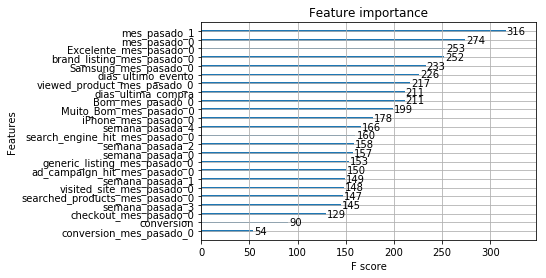

In [46]:
# Importancia de los features
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

In [194]:
# Ahora quiero mejorar los hiperparametros
from sklearn.model_selection import *

In [191]:
xgb_model = xgb.XGBRegressor()

In [192]:
parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.05],
              'gamma' : [0],
              'max_depth': [6],
              'min_child_weight': [1],
              'silent': [1],
              'subsample': [1],
              'colsample_bytree': [0.3],
              'n_estimators': [130],
              'seed': [1337],
              'reg_alpha' : [0.01]
             }

In [195]:
clf = GridSearchCV(xgb_model, parameters, n_jobs=3, 
                   scoring='roc_auc',
                   verbose=2, refit=True)

In [196]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] reg_alpha=0.01, colsample_bytree=0.3, silent=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=130, subsample=1, seed=1337, objective=binary:logistic, max_depth=6, gamma=0 
[CV] reg_alpha=0.01, colsample_bytree=0.3, silent=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=130, subsample=1, seed=1337, objective=binary:logistic, max_depth=6, gamma=0 
[CV] reg_alpha=0.01, colsample_bytree=0.3, silent=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=130, subsample=1, seed=1337, objective=binary:logistic, max_depth=6, gamma=0 
[CV]  reg_alpha=0.01, colsample_bytree=0.3, silent=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=130, subsample=1, seed=1337, objective=binary:logistic, max_depth=6, gamma=0, total=  16.5s
[CV]  reg_alpha=0.01, colsample_bytree=0.3, silent=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=130, subsample=1, seed=1337,

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   18.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'reg_alpha': [0.01], 'learning_rate': [0.05], 'n_estimators': [130], 'seed': [1337], 'colsample_bytree': [0.3], 'silent': [1], 'nthread': [4], 'min_child_weight': [1], 'subsample': [1], 'objective': ['binary:logistic'], 'max_depth': [6], 'gamma': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [197]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

('Raw AUC score:', 0.8462370533965604)
colsample_bytree: 0.3
gamma: 0
learning_rate: 0.05
max_depth: 6
min_child_weight: 1
n_estimators: 130
nthread: 4
objective: 'binary:logistic'
reg_alpha: 0.01
seed: 1337
silent: 1
subsample: 1


/home/lautaro/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [94]:
# Ahora tengo que predecir los de prueba de Kaggle
ids_usuarios_kaggle = pd.read_csv('/home/lautaro/Desktop/trocafone_kaggle_test.csv')

In [95]:
x_test_kaggle = usuarios.loc[usuarios['person'].isin(ids_usuarios_kaggle['person']), :]

In [96]:
x_test_kaggle.head()

,person,brand_listing_mes_pasado_0,semana_pasada_4,search_engine_hit_mes_pasado_0,ad_campaign_hit_mes_pasado_0,mes_pasado_0,Bom_mes_pasado_0,conversion,semana_pasada_2,semana_pasada_3,...,dias_ultima_compra,Excelente_mes_pasado_0,visited_site_mes_pasado_0,iPhone_mes_pasado_0,Muito_Bom_mes_pasado_0,searched_products_mes_pasado_0,generic_listing_mes_pasado_0,Samsung_mes_pasado_0,dias_ultimo_evento,viewed_product_mes_pasado_0
1,00091926,25.0,33.0,0.0,15.0,448.0,102.0,0.0,167.0,132.0,...,151,108.0,34.0,253.0,163.0,0.0,0.0,61.0,0,372.0
2,00091a7a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66,0.0
3,000ba417,24.0,0.0,1.0,1.0,206.0,115.0,1.0,68.0,0.0,...,5,11.0,6.0,8.0,34.0,0.0,14.0,110.0,5,153.0
5,000e4d9e,17.0,0.0,5.0,19.0,411.0,124.0,0.0,195.0,0.0,...,151,53.0,13.0,21.0,163.0,0.0,17.0,301.0,1,339.0
6,000e619d,11.0,0.0,3.0,6.0,68.0,14.0,0.0,68.0,0.0,...,151,7.0,5.0,7.0,8.0,6.0,8.0,12.0,13,28.0


In [97]:
x_test_kaggle = x_test_kaggle.set_index('person')

In [98]:
# Predecimos
preds_kaggle = xg_reg.predict(x_test_kaggle)

In [99]:
preds_kaggle

array([0.06488177, 0.14496508, 0.05996173, ..., 0.08157521, 0.07266716,
       0.01542386], dtype=float32)

In [100]:
pd.DataFrame({'person': x_test_kaggle.index, 'label': preds_kaggle}).to_csv('test.csv', index=False, columns=['person', 'label'])